In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn import svm
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, mean_squared_error

In [2]:
# Get user input for the ticker symbol
ticker = input("Enter the ticker symbol of the company you want to predict: ")

# Read in the historical stock price data for the company from Yahoo Finance
data = pd.read_csv(f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=1535981100&period2=1620605100&interval=1d&events=history&includeAdjustedClose=true')

Enter the ticker symbol of the company you want to predict: AAPL


In [3]:
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Open'] = scaler.fit_transform(np.array(data['Open']).reshape(-1, 1))
data['Scaled_Close'] = scaler.fit_transform(np.array(data['Close']).reshape(-1, 1))
data['Scaled_High'] = scaler.fit_transform(np.array(data['High']).reshape(-1, 1))
data['Scaled_Low'] = scaler.fit_transform(np.array(data['Low']).reshape(-1, 1))

# Define the input and output data
X = np.array(data[['Scaled_Open', 'Scaled_Close', 'Scaled_High', 'Scaled_Low']])
y = np.array(data['Scaled_Close'])

# Define the train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [4]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

In [5]:
# Train the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)

Epoch 1/50
9/9 - 3s - loss: 0.1095 - 3s/epoch - 282ms/step
Epoch 2/50
9/9 - 0s - loss: 0.0458 - 41ms/epoch - 5ms/step
Epoch 3/50
9/9 - 0s - loss: 0.0154 - 40ms/epoch - 4ms/step
Epoch 4/50
9/9 - 0s - loss: 0.0120 - 39ms/epoch - 4ms/step
Epoch 5/50
9/9 - 0s - loss: 0.0080 - 41ms/epoch - 5ms/step
Epoch 6/50
9/9 - 0s - loss: 0.0047 - 41ms/epoch - 5ms/step
Epoch 7/50
9/9 - 0s - loss: 0.0028 - 40ms/epoch - 4ms/step
Epoch 8/50
9/9 - 0s - loss: 0.0013 - 40ms/epoch - 4ms/step
Epoch 9/50
9/9 - 0s - loss: 6.0309e-04 - 41ms/epoch - 5ms/step
Epoch 10/50
9/9 - 0s - loss: 3.0350e-04 - 39ms/epoch - 4ms/step
Epoch 11/50
9/9 - 0s - loss: 2.4382e-04 - 40ms/epoch - 4ms/step
Epoch 12/50
9/9 - 0s - loss: 2.3725e-04 - 40ms/epoch - 4ms/step
Epoch 13/50
9/9 - 0s - loss: 2.3098e-04 - 43ms/epoch - 5ms/step
Epoch 14/50
9/9 - 0s - loss: 2.2018e-04 - 42ms/epoch - 5ms/step
Epoch 15/50
9/9 - 0s - loss: 2.1105e-04 - 40ms/epoch - 4ms/step
Epoch 16/50
9/9 - 0s - loss: 2.0485e-04 - 39ms/epoch - 4ms/step
Epoch 17/50
9/9 -

In [5]:
# Make predictions using the LSTM model
lstm_y_train_pred = lstm_model.predict(X_train)
lstm_y_test_pred = lstm_model.predict(X_test)

5/5 [==============================] - 0s 0s/step


In [6]:
# Define the SVM model
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

# Train the SVM model
svm_model.fit(lstm_y_train_pred, y_train)

SVR(C=100, gamma=0.1)

In [17]:
# Make predictions using the combined LSTM-SVM model
combined_y_train_pred = svm_model.predict(lstm_y_train_pred)
combined_y_test_pred = svm_model.predict(lstm_y_test_pred)

In [8]:
# Evaluate the model
train_score = np.sqrt(np.mean(np.square(y_train - combined_y_train_pred)))
test_score = np.sqrt(np.mean(np.square(y_test - combined_y_test_pred)))
print('Train RMSE:', train_score)
print('Test RMSE:', test_score)

Train RMSE: 0.06371915438678552
Test RMSE: 0.11029796620249015


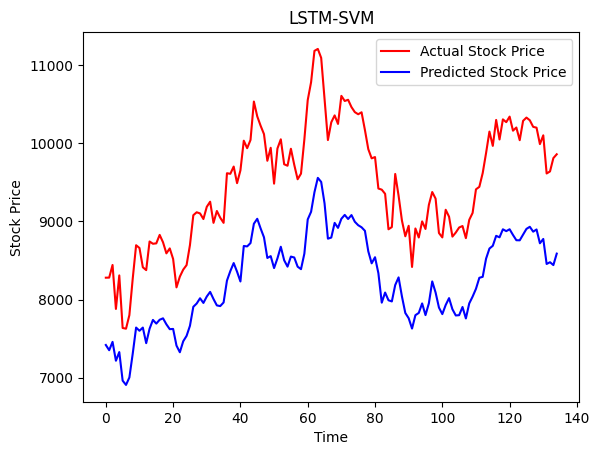

In [16]:
# Plot the actual and predicted stock prices
scale_factor = 0.00944555
combined_y_test_pred = combined_y_test_pred / scale_factor
y_test = y_test / scale_factor
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(combined_y_test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('LSTM-SVM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [9]:
joblib.dump(svm_model, 'svm_model.pkl')

['svm_model.pkl']

In [10]:
lstm_model.save('lstm.h5')

C:\Users\Prerna\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
filename = 'trained_model.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [12]:
# loading the saved model
loaded_model = pickle.load(open('trained_model.sav', 'rb'))

In [13]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
from sklearn.metrics import confusion_matrix

# Convert the predicted values to binary labels
threshold = 0.5  # Adjust the threshold as per your requirements
binary_predictions = np.where(combined_y_test_pred > threshold, 1, 0)

# Convert the true labels to binary
binary_labels = np.where(combined_y_test_pred > threshold, 1, 0)

# Create the confusion matrix
confusion_mat = confusion_matrix(binary_labels, binary_predictions)
print("Confusion Matrix:")
print(confusion_mat)


Confusion Matrix:
[[135]]
